In [3]:
from pyqpanda.Hamiltonian import (PauliOperator, 
                                  chem_client)
from pyqpanda.Hamiltonian.QubitOperator import *
from pyqpanda import *
from pyqpanda.utils import *
from pyqpanda.Algorithm.hamiltonian_simulation import *

geometry=[['N',[0,0,0]], ['N',[0,0,0.74]]]


basis="sto-3g"
multiplicity=1
charge=0
run_mp2=True
run_cisd=True
run_ccsd=True
run_fci=True

str1=chem_client(
        geometry=geometry,
        basis=basis,
        multiplicity=multiplicity,
        charge=charge,
        run_mp2=run_mp2,
        run_cisd=run_cisd,
        run_ccsd=run_ccsd,
        run_fci=run_fci,
        hamiltonian_type="pauli")



In [5]:
#print(str1)
s=str1.split('\n')
print(len(s))

2239


In [2]:
# convert to PauliOperator

def convert_operator(str):
    terms=str.split(' +\n')
    tuplelist=dict()
    for term in terms:
        data=term.split(' ',1)        
        tuplelist[data[1][1:-1]]=eval(data[0])

    operator=PauliOperator(tuplelist)    
    return operator

In [3]:
import numpy as np
from numpy.linalg import eig
# definition of to_dense
Z=np.array([[1,0],[0,-1]])
X=np.array([[0,1],[1,0]])
Y=np.array([[0,-1j],[1j,0]])
I=np.eye(2)

pauli_mat={'I':I,'X':X,'Y':Y,'Z':Z}

def krons(matlist):
    mat=np.array([1])
    for term in matlist:
        mat=np.kron(mat,term)
        
    return mat

def get_dense_pauli(pauli_tuple, n_qubit):
    result=np.array([1],dtype='complex128')
    for i in range(n_qubit):
        if i == pauli_tuple[1]:
            result=np.kron(result, pauli_mat[pauli_tuple[0]])
        else:
            result=np.kron(result,I)
    return result

def get_matrix(pauliOperator):
    op=pauliOperator.ops
    n_qubit=pauliOperator.get_qubit_count()
    
    #preparation for numpy array
    I_=np.eye(1<<n_qubit,dtype='complex128')
    result=np.zeros((1<<n_qubit,1<<n_qubit),dtype='complex128')
    
    for term in op:
        one_term_result=deepcopy(I_)
        tuplelist=PauliOperator.parse_pauli(term)
        for pauli_tuple in tuplelist:
            one_term_result=one_term_result.dot(get_dense_pauli(pauli_tuple,n_qubit))
        result+=one_term_result*op[term]
    return result

In [4]:
# try to reconstruct the H2 energy

def H2_energy_from_distance(distance):
    geometry=[['H',[0,0,0]], ['H',[0,0,distance]]]
    
    basis="sto-3g"
    multiplicity=1
    charge=0
    run_mp2=True
    run_cisd=True
    run_ccsd=True
    run_fci=True

    str1=chem_client(
            geometry=geometry,
            basis=basis,
            multiplicity=multiplicity,
            charge=charge,
            run_mp2=run_mp2,
            run_cisd=run_cisd,
            run_ccsd=run_ccsd,
            run_fci=run_fci,
            hamiltonian_type="pauli")
    
    pauli_op=convert_operator(str1)
    matrix_=get_matrix(pauli_op)
    eigval,_=eig(matrix_)
    return min(eigval).real

distance_range=np.linspace(0.25,2.5,50)
energy=np.zeros(len(distance_range))

for i,distance in enumerate(distance_range):
    print('{} / {}'.format(i+1,len(distance_range)))
    energy[i]=H2_energy_from_distance(distance)
    
from matplotlib.pyplot import *

1 / 50
2 / 50
3 / 50
4 / 50
5 / 50
6 / 50
7 / 50
8 / 50
9 / 50
10 / 50
11 / 50
12 / 50
13 / 50
14 / 50
15 / 50
16 / 50
17 / 50
18 / 50
19 / 50
20 / 50
21 / 50
22 / 50
23 / 50
24 / 50
25 / 50
26 / 50
27 / 50
28 / 50
29 / 50
30 / 50
31 / 50
32 / 50
33 / 50
34 / 50
35 / 50
36 / 50
37 / 50
38 / 50
39 / 50
40 / 50
41 / 50
42 / 50
43 / 50
44 / 50
45 / 50
46 / 50
47 / 50
48 / 50
49 / 50
50 / 50


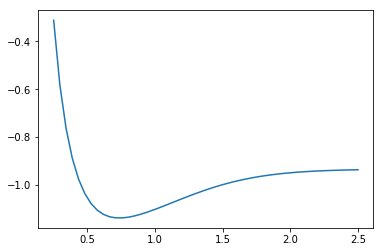

-0.93605491984427658

In [5]:
plot(distance_range,energy)
show()

energy[-1]

In [6]:
Atom_Name=['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'He', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl']
Atom_Electron=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
Atom_Dict=dict()
for i in range(len(Atom_Name)):
    Atom_Dict[Atom_Name[i]]=Atom_Electron[i]
    
def get_electron_count(geometry):
    n_electron = 0
    for atom in geometry:
        n_electron+=Atom_Dict[atom[0]]
    return n_electron

operator=convert_operator(str1)
n_qubit = operator.get_qubit_count()
n_electron=get_electron_count(geometry)

def get_fermion_jordan_wigner(fermion_type, op_qubit):
    '''
    fermion_op = ('a',1) or ('c',1)
    'a' is for annihilation
    'c' is for creation
    '''
    opstr=''
    for i in range(op_qubit):
        opstr=opstr+'Z'+str(i)+' '
    
    opstr1=opstr+'X'+str(op_qubit)
    opstr2=opstr+'Y'+str(op_qubit)
    if fermion_type == 'a':
        return PauliOperator({opstr1:1,opstr2:1j})
    elif fermion_type == 'c':
        return PauliOperator({opstr1:1,opstr2:-1j})
    else:
        assert False
        
def get_ccs_n_term(n_qubit, n_electron):
    if n_electron>n_qubit:
        assert False
    elif n_electron==n_qubit:
        return 0
    param_n=0
    # ccsd is each electron jump to the excited level, and also each two
    result_op=PauliOperator(dict())
    for i in range(n_electron):
        for ex in range(n_electron, n_qubit):
            param_n+=1
                    
    return param_n

def get_ccsd_n_term(n_qubit, n_electron):
    if n_electron>n_qubit:
        assert False
    elif n_electron==n_qubit:
        return 0
    param_n=0
    # ccsd is each electron jump to the excited level, and also each two
    result_op=PauliOperator(dict())
    for i in range(n_electron):
        for ex in range(n_electron, n_qubit):
            param_n+=1
    
    for i in range(n_electron):
        for j in range(i+1,n_electron):
            for ex1 in range(n_electron,n_qubit):
                for ex2 in range(ex1+1,n_qubit):
                    param_n+=1
                    
    return param_n

def get_ccs(n_qubit, n_electron, param_list):
    if n_electron>n_qubit:
        assert False
    elif n_electron==n_qubit:
        return PauliOperator(dict())
    param_n=0
    # ccsd is each electron jump to the excited level, and also each two
    result_op=PauliOperator(dict())
    for i in range(n_electron):
        for ex in range(n_electron, n_qubit):
            result_op+=get_fermion_jordan_wigner('c',ex)*get_fermion_jordan_wigner('a',i)*param_list[param_n]
            param_n+=1
            
    return result_op
        
def get_ccsd(n_qubit, n_electron, param_list):
    if n_electron>n_qubit:
        assert False
    elif n_electron==n_qubit:
        return PauliOperator(dict())
    param_n=0
    # ccsd is each electron jump to the excited level, and also each two
    result_op=PauliOperator(dict())
    for i in range(n_electron):
        for ex in range(n_electron, n_qubit):
            result_op+=get_fermion_jordan_wigner('c',ex)*get_fermion_jordan_wigner('a',i)*param_list[param_n]
            param_n+=1
    
    for i in range(n_electron):
        for j in range(i+1,n_electron):
            for ex1 in range(n_electron,n_qubit):
                for ex2 in range(ex1+1,n_qubit):
                    result_op+=get_fermion_jordan_wigner('c',ex2)* \
                               get_fermion_jordan_wigner('c',ex1)* \
                               get_fermion_jordan_wigner('a',j)*   \
                               get_fermion_jordan_wigner('a',i)* param_list[param_n]
                    param_n+=1
                    
    return result_op
                
n_param=get_ccs_n_term(n_qubit,n_electron)
paramlist=np.ones(n_param)*0.5
op1=get_ccs(n_qubit,n_electron,paramlist)
print(op1)

{'Y0 Z1 X2': 0.5j, 'X0 Z1 X2': (0.5+0j), 'Y0 Z1 Y2': (0.5+0j), 'X0 Z1 Y2': -0.5j, 'Y0 Z1 Z2 X3': 0.5j, 'X0 Z1 Z2 X3': (0.5+0j), 'Y0 Z1 Z2 Y3': (0.5+0j), 'X0 Z1 Z2 Y3': -0.5j, 'Y1 X2': 0.5j, 'X1 X2': (0.5+0j), 'Y1 Y2': (0.5+0j), 'X1 Y2': -0.5j, 'Y1 Z2 X3': 0.5j, 'X1 Z2 X3': (0.5+0j), 'Y1 Z2 Y3': (0.5+0j), 'X1 Z2 Y3': -0.5j}


In [7]:
def dagger(pauliOperator):
    new_ops=deepcopy(pauliOperator.ops)
    for term in new_ops:
        new_ops[term]=new_ops[term].real-new_ops[term].imag*1j
    return PauliOperator(new_ops)

def cc_to_ucc_hamiltonian(cc_op):
    return 1j*(cc_op-dagger(cc_op))

ucc=cc_to_ucc_hamiltonian(op1)
print(ucc)

{'Y0 Z1 X2': (-1+0j), 'X0 Z1 Y2': (1+0j), 'Y0 Z1 Z2 X3': (-1+0j), 'X0 Z1 Z2 Y3': (1+0j), 'Y1 X2': (-1+0j), 'X1 Y2': (1+0j), 'Y1 Z2 X3': (-1+0j), 'X1 Z2 Y3': (1+0j)}


In [8]:
complex(1.5)

(1.5+0j)

In [9]:
print(convert_operator(str1))

{'': (-0.09706627236102515+0j), 'X0 X1 Y2 Y3': (-0.04530261554936542+0j), 'X0 Y1 Y2 X3': (0.04530261554936542+0j), 'Y0 X1 X2 Y3': (0.04530261554936542+0j), 'Y0 Y1 X2 X3': (-0.04530261554936542+0j), 'Z0': (0.17141282594679685+0j), 'Z0 Z1': (0.16868898154816542+0j), 'Z0 Z2': (0.1206252346467246+0j), 'Z0 Z3': (0.16592785019609002+0j), 'Z1': (0.17141282594679685+0j), 'Z1 Z2': (0.16592785019609002+0j), 'Z1 Z3': (0.1206252346467246+0j), 'Z2': (-0.22343153540326133+0j), 'Z2 Z3': (0.17441287597259206+0j), 'Z3': (-0.22343153540326133+0j)}


In [10]:
def flatten(pauliOperator):
    new_ops=deepcopy(pauliOperator.ops)
    for term in new_ops:
        if abs(new_ops[term].imag)<pauliOperator.m_error_threshold:
            new_ops[term]=float(new_ops[term].real)
        else:
            assert False
    return PauliOperator(new_ops)
ucc=flatten(ucc)
print(ucc)

{'Y0 Z1 X2': -1.0, 'X0 Z1 Y2': 1.0, 'Y0 Z1 Z2 X3': -1.0, 'X0 Z1 Z2 Y3': 1.0, 'Y1 X2': -1.0, 'X1 Y2': 1.0, 'Y1 Z2 X3': -1.0, 'X1 Z2 Y3': 1.0}


In [11]:
init()
prog=QProg()
q=qAlloc_many(n_qubit)
c=cAlloc_many(n_qubit)
print(n_qubit)
#prog.insert(simulate_hamiltonian(qubit_list=q,pauliOperator=ucc,t=1.,slices=3))
#print(to_qrunes(prog))

4


In [12]:
def transform_base(qubitlist,base):
    qcircuit=QCircuit()
    for i in range(0,len(base),3):
        if base[i]=='X':
            qcircuit.insert(H(qubitlist[int(base[i+1])]))
        elif base[i]=='Y':
            qcircuit.insert(RX(qubitlist[int(base[i+1])],pi/2))
        elif base[i]=='Z':
            pass
        else:
            assert False
    return qcircuit
base='Y0 Z1 X2'
prog1=QProg()
prog1.insert(transform_base(q,base))
print(to_qrunes(prog1))   

#QUBITS_NUM 4
#CREGS_NUM 4
RX 0,"1.570796"
H 2



In [13]:
def parity_check(string, paulis):
    check=0
    
    tuplelist=PauliOperator.parse_pauli(paulis)
    qubit_idx_list=list()
    for term in tuplelist:
        qubit_idx_list.append(term[1])
    
    for i in qubit_idx_list:
        if string[i]=='1':
            check+=1
    
    return check%2        

In [14]:
#e.g. component=('X0 Y1 Z2',0.33)
def get_expectation(qubit_number,unitaryCC,component,shots_):
    init()
    prog=QProg()
    q=qAlloc_many(qubit_number)
    c=cAlloc_many(qubit_number)
    prog.insert(RX(q[0],pi)).insert(RX(q[2],pi))
    #print(unitaryCC)
    prog.insert(simulate_hamiltonian(qubit_list=q,pauliOperator=unitaryCC,t=1,slices=3))
    if component[0]!='':
        prog.insert(transform_base(q,component[0]))
    #print(to_qrunes(prog))
    directly_run(QProg=prog)
    result=get_probabilites(q, select_max=-1, dataType="dict")
    finalize()
    expectation=0
    for i in result:
        if parity_check(i, component[0]):
            expectation-=result[i]
        else:
            expectation+=result[i]       
    #print(result)
    return expectation*component[1]
    
    '''
    result=quick_measure(q, shots_)
    finalize()
    #print(result)
    expectation=0
    for i in result:
        if parity_check(i, component[0]):
            expectation-=result[i]
        else:
            expectation+=result[i]
    expectation=float(expectation)       
    return expectation/shots_*component[1]
    '''

qubit_number=4
electron_number=2
#initial stata
n_param=get_ccs_n_term(qubit_number,electron_number)
#initial parameter
paramlist=np.ones(n_param)*0.1
op1=get_ccs(n_qubit,n_electron,paramlist)
ucc=cc_to_ucc_hamiltonian(op1)
ucc=flatten(ucc)
component=('Z0 Z1 Z2',0.23)
exp=get_expectation(qubit_number,ucc,component,shots_=1000)
print(exp)
 

0.21184402862066373


In [15]:
def vqe_subroutine(qubit_number_,electron_number,Hamiltonian,unitaryCC_,shots):
    #initial stata
    #print(Hamiltonian.ops)
    #matrix=get_matrix(Hamiltonian)
    #eigv,eigg=eig(matrix)
    #print(eigv)
    #print(eigg)
    expectation=0
    for component in Hamiltonian.ops:
        #print(component)
        temp=(component,Hamiltonian.ops[component])
        expectation+=get_expectation(qubit_number=qubit_number_,unitaryCC=unitaryCC_,component=temp,shots_=shots)
    return expectation

qubit_number=4
electron_number=2
n_param=get_ccs_n_term(qubit_number,electron_number)
#initial parameter
paramlist=np.ones(n_param)*0.5
op1=get_ccs(n_qubit,n_electron,paramlist)
ucc=cc_to_ucc_hamiltonian(op1)
ucc=flatten(ucc)
exp= vqe_subroutine(qubit_number,electron_number,convert_operator(str1),unitaryCC_=ucc,shots=1000)
print(exp)



(-0.3886816248605904+0j)


In [16]:
from scipy.optimize import minimize
from functools import partial
def binding(qubit_number,electron_number,Hamiltonian,shots):
    return partial(vqe_in_list,
                    qubit_number=qubit_number,
                    electron_number=electron_number,
                    Hamiltonian=Hamiltonian,
                    shots=shots)
def vqe_in_list(arguments,qubit_number,electron_number,Hamiltonian,shots):
    op1=get_ccs(n_qubit,n_electron,arguments)
    ucc=cc_to_ucc_hamiltonian(op1)
    ucc=flatten(ucc)
    expectation=0
    for component in Hamiltonian.ops:
        #print(component)
        temp=(component,Hamiltonian.ops[component])
        expectation+=get_expectation(qubit_number=qubit_number,unitaryCC=ucc,component=temp,shots_=shots)
    expectation=float(expectation.real)
    return expectation
def H2_vqe_subprocess(distance):
    geometry=[['H',[0,0,0]], ['H',[0,0,distance]]]
    
    basis="sto-3g"
    multiplicity=1
    charge=0
    run_mp2=True
    run_cisd=True
    run_ccsd=True
    run_fci=True

    str1=chem_client(
            geometry=geometry,
            basis=basis,
            multiplicity=multiplicity,
            charge=charge,
            run_mp2=run_mp2,
            run_cisd=run_cisd,
            run_ccsd=run_ccsd,
            run_fci=run_fci,
            hamiltonian_type="pauli")
    
    Hamiltonian=convert_operator(str1)
    n_qubit = Hamiltonian.get_qubit_count()
    n_electron=get_electron_count(geometry)
    n_param=get_ccs_n_term(n_qubit,n_electron)
    #initial_guess
    initial_guess=np.ones(n_param)*0.5
    result=minimize(binding(n_qubit,n_electron,Hamiltonian,5000),initial_guess,method="Powell")
    return result
result=H2_vqe_subprocess(0.64)
a=result.fun
print(a)
print(result)

-1.111296028524694
   direc: array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.00877657,  0.86339178, -0.534511  ,  0.13091851],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [-0.32939813,  0.09675982, -0.0252938 , -0.4609624 ]])
     fun: array(-1.111296028524694)
 message: 'Optimization terminated successfully.'
    nfev: 436
     nit: 9
  status: 0
 success: True
       x: array([ -1.10219205e-03,   3.14138200e+00,  -7.86089527e-01,
         1.87800369e-03])


In [17]:
from matplotlib.pyplot import *
def H2_vqe(distance_range):
    energy=np.zeros(len(distance_range))
    for i in range(len(distance_range)):
        print(i)
        result=H2_vqe_subprocess(distance_range[i])
        energy[i]=result.fun
        print(energy[i])
    return energy

distance_range=np.linspace(0.25,2.5,50)
energyvqe=H2_vqe(distance_range)

0
-0.304860985839
1
-0.574646914091
2
-0.754882641632
3
-0.878435737257
4
-0.963911459316
5
-1.02308332718
6
-1.06342503461
7
-1.08996237472
8
-1.1062422953
9
-1.11479188236
10
-1.11747399524
11
-1.11575238482
12
-1.11069207905
13
-1.1029493469
14
-1.09343967893
15
-1.08223970292
16
-1.07013542181
17
-1.05712508561
18
-1.04357847197
19
-1.02952033582
20
-1.0152953123
21
-1.00265643601
22
-0.991962763461
23
-0.982899833026
24
-0.975239398484
25
-0.968754278092
26
-0.963271225264
27
-0.958635383632
28
-0.954710818165
29
-0.951403941164
30
-0.904488899219
31
-0.908341305476
32
-0.911698668435
33
-0.91462165151
34
-0.917163809435
35
-0.919372423229
36
-0.921289201123
37
-0.922950904367
38
-0.924389905445
39
-0.925634684841
40
-0.926710273052
41
-0.927638643701
42
-0.928439063569
43
-0.929128404472
44
-0.929721421669
45
-0.930231002256
46
-0.930668387004
47
-0.931043368289
48
-0.931364466466
49
-0.931639086742


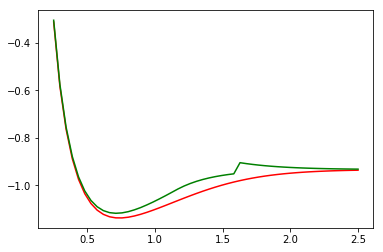

-0.93605491984427658

In [18]:
from matplotlib.pyplot import *
plot(distance_range,energy,'r',distance_range,energyvqe,'g')
#plt.plot(x,y,'ro',x,y1,'g--')
show()
energy[-1]